In [29]:


# Importing the necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import norm
import datetime 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet


In [3]:
# Setting random seed for reproducibility
np.random.seed(3363)

In [4]:
# Using an API call to access the Natural Gas Futures data

ticker = "NGUSD" #US natural gas
base = 'https://financialmodelingprep.com/api/v3/'
key = "TCMWd4TwIN9jqyUgdy4Zl3F1zPbPFj0n"
target = "{}historical-price-full/{}?apikey={}".format(base, ticker, key)

In [6]:
# Saving the file into a dataframe
df = pd.read_json(target)
df = pd.json_normalize(df['historical'])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Inspecting the dataframe
df.head()

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
date,,,,,,,,,,,,
2024-05-30,2.662,2.682,2.417,2.608,2.608,5649,5649,-0.054,-2.02855,2.57,"May 30, 24",-0.020285
2024-05-29,2.594,2.669,2.417,2.457,2.457,2512,2512,-0.137,-5.28000,2.51,"May 29, 24",-0.052800
2024-05-28,2.503,2.621,2.475,2.590,2.590,51814,51814,0.087,3.48000,2.56,"May 28, 24",0.034800
2024-05-27,2.503,2.582,2.475,2.511,2.511,6426,6426,0.008,0.31962,2.52,"May 27, 24",0.003196
2024-05-26,2.503,2.503,2.479,2.480,2.480,92,92,-0.023,-0.91890,2.49,"May 26, 24",-0.009189


<Axes: title={'center': 'Price of NGUSD from 2019-05-31 00:00:00 to 2024-05-30 00:00:00'}, xlabel='date'>

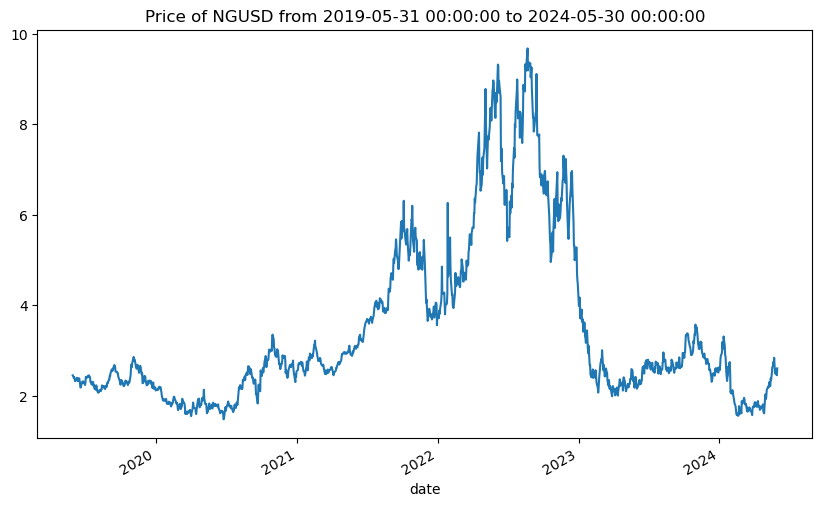

In [7]:
#Plot of asset historical closing price from 2020 to 2024
df['adjClose'].plot(figsize=(10, 6), title = "Price of {} from {} to {}".format(ticker, df.index.min(), df.index.max()))

# Monte Carlo Simulation for Natural Gas Futures Prediction

The Monte Carlo simulation involves running a large number of simulations to model the future price movements of natural gas based on historical data.


In [8]:
# Compute the daily returns, which are the percent changes in the closin prices.

df["daily_return"] = df["close"].pct_change()

In [9]:
# Set parameters for the Monte Carlo simulation

num_simulations = 1000
num_days = 14
last_price = df["close"].iloc[-1]

In [10]:
simulation_df = pd.DataFrame()

for x in range(num_simulations):
    prices = [last_price]
    for _ in range(num_days):
        daily_return = np.random.choice(df['daily_return'].dropna())
        prices.append(prices[-1] * (1 + daily_return))
    simulation_df[x] = prices
        

C:\Users\karol\AppData\Local\Temp\ipykernel_8764\3129572853.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_df[x] = prices


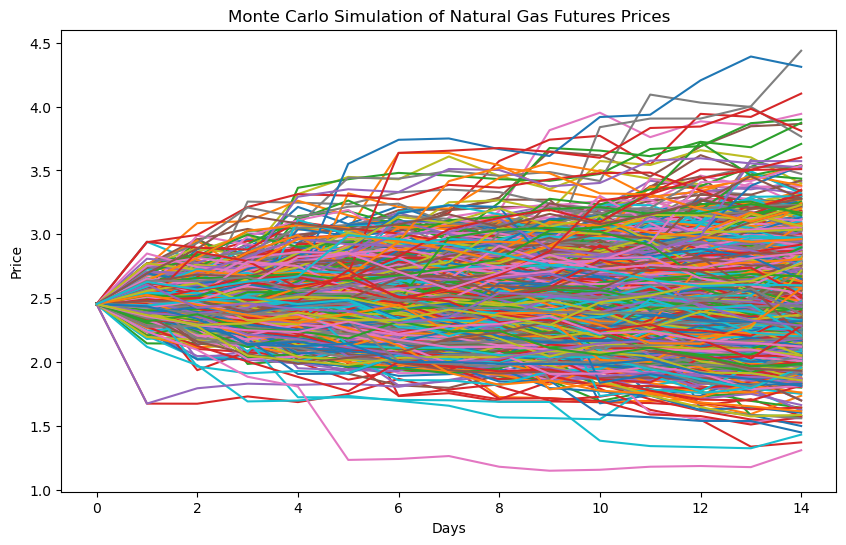

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(simulation_df)
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Simulation of Natural Gas Futures Prices')
plt.show()

# Analysis of Monte Carlo Simulation for Natural Gas Futures (14 Days)

The Monte Carlo simulation plot for natural gas futures over a 14-day period shows multiple potential price paths:

- **Price Range**: The prices vary from around $1.5 to $5, indicating significant uncertainty in short-term price movements.
- **Central Tendency**: Most price paths hover around the initial price of $2.5, suggesting a central tendency.
- **Volatility**: The wide spread of the paths reflects high volatility in natural gas prices.


# Extracting Data from Monte Carlo Simulation for Statistical Analysis

Now we extract some of the data from the Monte Carlo simulation and do some basic statistical analysis on it.


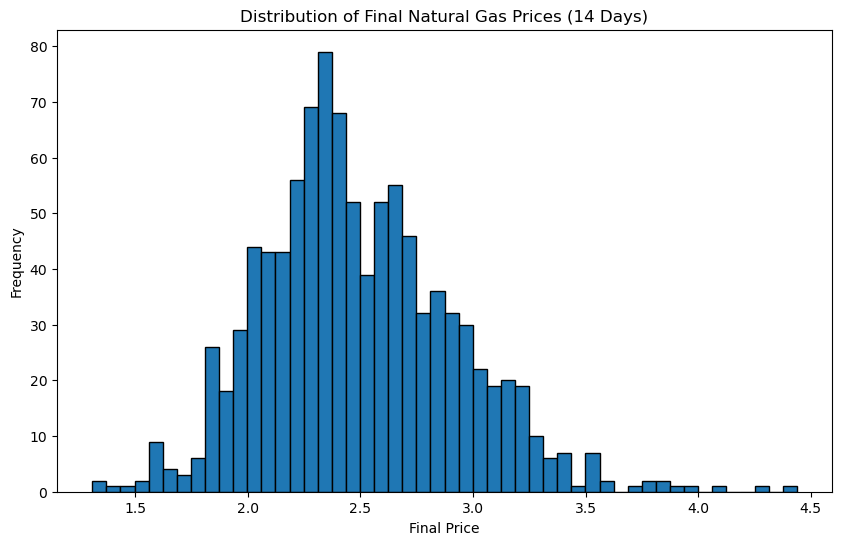

In [12]:
# Extract the final prices from the simulation
final_prices = simulation_df.iloc[-1, :]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(final_prices, bins=50, edgecolor='k')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.title('Distribution of Final Natural Gas Prices (14 Days)')
plt.show()

# Analysis of the Distribution of Final Natural Gas Prices (14 Days)

The histogram above represents the distribution of final natural gas prices over a 14-day forecast period based on Monte Carlo simulations. Key observations from the graph include:

- **Central Tendency**: The majority of the final prices are clustered around the $2.0 to $3.0 range, indicating that this is the most likely price range for natural gas at the end of the 14-day period.
- **Skewness**: The distribution appears to be slightly right-skewed, with a longer tail extending towards higher prices. This suggests there are occasional simulations predicting higher prices, but they are less frequent.
- **Spread**: The prices range from approximately $1.5 to $4.5, showing a broad spread of potential outcomes, which reflects the uncertainty in the market.
- **Peak Frequency**: The highest frequency of final prices is around $2.5, which can be considered the mode of the distribution.

This analysis indicates a higher probability of natural gas prices settling around $2.0 to $3.0 over the next 14 days, with occasional scenarios predicting higher or lower prices.


In [13]:
mean_price = final_prices.mean()
median_price = final_prices.median()
std_dev = final_prices.std()

print(f"Mean Final Price: {mean_price:.2f}")
print(f"Median Final Price: {median_price:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")

Mean Final Price: 2.49
Median Final Price: 2.43
Standard Deviation: 0.43


In [14]:
confidence_level = 0.95
z_score = 1.96  # For 95% confidence

margin_of_error = z_score * std_dev / np.sqrt(num_simulations)
confidence_interval = (mean_price - margin_of_error, mean_price + margin_of_error)

print(f"95% Confidence Interval: {confidence_interval[0]:.2f} to {confidence_interval[1]:.2f}")

95% Confidence Interval: 2.47 to 2.52


# Time Series Forecasting of Natural Gas Prices 

In [15]:
# Formatting the dataframe for the timeseries forescast
df_forecast = df.reset_index().copy()

In [16]:
df_forecast = df_forecast[["date", "close"]].rename(columns={"date":"ds", "close": "y"})

In [17]:
df_forecast.head()

,ds,y
0,2024-05-30,2.608
1,2024-05-29,2.457
2,2024-05-28,2.590
3,2024-05-27,2.511
4,2024-05-26,2.480


In [28]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1347 entries, 0 to 1346
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1347 non-null   datetime64[ns]
 1   y       1347 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.2 KB


In [18]:
# Initialize the model

model = Prophet()

In [19]:
# Fit the model
model.fit(df_forecast)

18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:40 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Make a future datframe
future = model.make_future_dataframe(periods=30)

In [21]:
# Make predictions
forecast = model.predict(future)

C:\Users\karol\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\karol\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


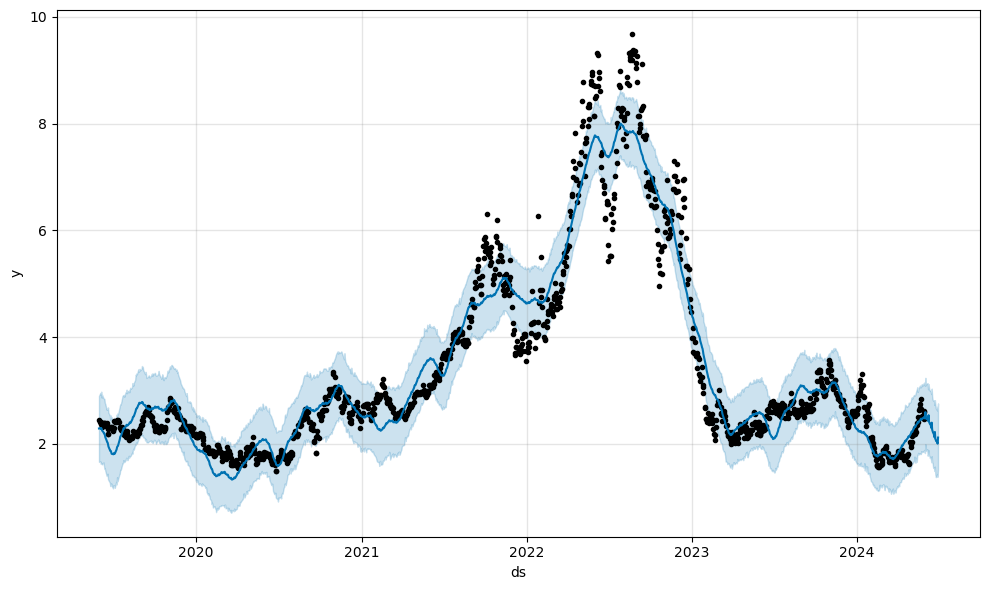

In [22]:
#Plot the forecast
fig1 = model.plot(forecast)
plt.show()

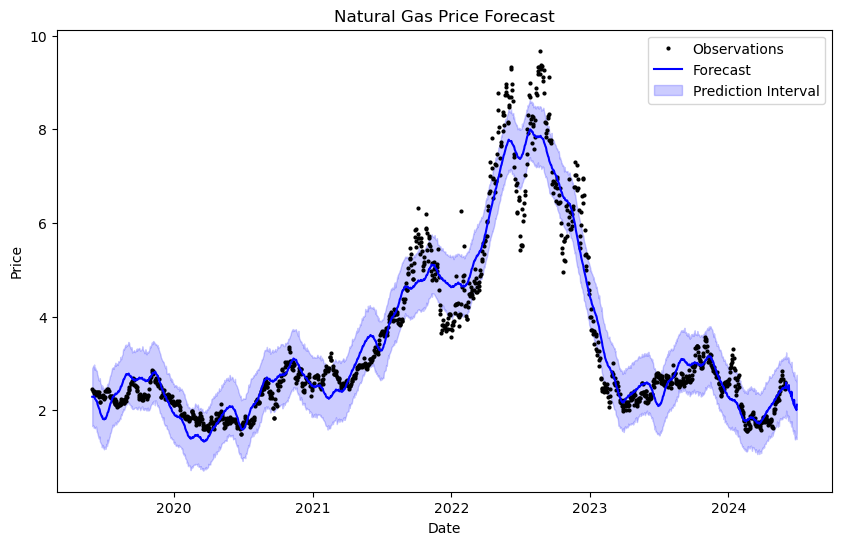

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot historical data
ax.plot(df_forecast['ds'], df_forecast['y'], 'ko', label='Observations', markersize=2)

# Plot forecast data
ax.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Prediction Interval')

# Formatting the plot
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Price Forecast')
ax.legend()

plt.show()

# Running metrics on the prediction


In [30]:
# Merge the forecast with the original data on the 'ds' column
merged_df = pd.merge(df_forecast, forecast[['ds', 'yhat']], on='ds')


In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1347 entries, 0 to 1346
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1347 non-null   datetime64[ns]
 1   y       1347 non-null   float64       
 2   yhat    1347 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 31.7 KB


In [32]:
# Calculate the error metrics
mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
mse = mean_squared_error(merged_df['y'], merged_df['yhat'])
rmse = np.sqrt(mse)


In [33]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.3543565799918926
Mean Squared Error (MSE): 0.2389946837170372
Root Mean Squared Error (RMSE): 0.48887082518497377


### Interpretation of Forecast Error Metrics

- **Mean Absolute Error (MAE): 0.354**
  - The average absolute difference between observed and predicted values is approximately \\$0.35. This indicates that, on average, the forecasted prices are off by about \\$0.35 from the actual prices.

- **Mean Squared Error (MSE): 0.239**
  - The average of the squared differences between observed and predicted values is approximately 0.239. This metric penalizes larger errors more heavily and provides a measure of overall model performance.

- **Root Mean Squared Error (RMSE): 0.489**
  - The typical prediction error is about \\$0.49. RMSE is in the same units as the original data, making it useful for understanding the overall accuracy of the model.

### Summary

The error metrics indicate that the model has an average absolute error of around \$0.35, with typical prediction errors being about \\$0.49. These values suggest that the model performs reasonably well in predicting natural gas prices, though some errors still exist. Further refinement and feature addition could improve the model's accuracy.



C:\Users\karol\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\karol\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\karol\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

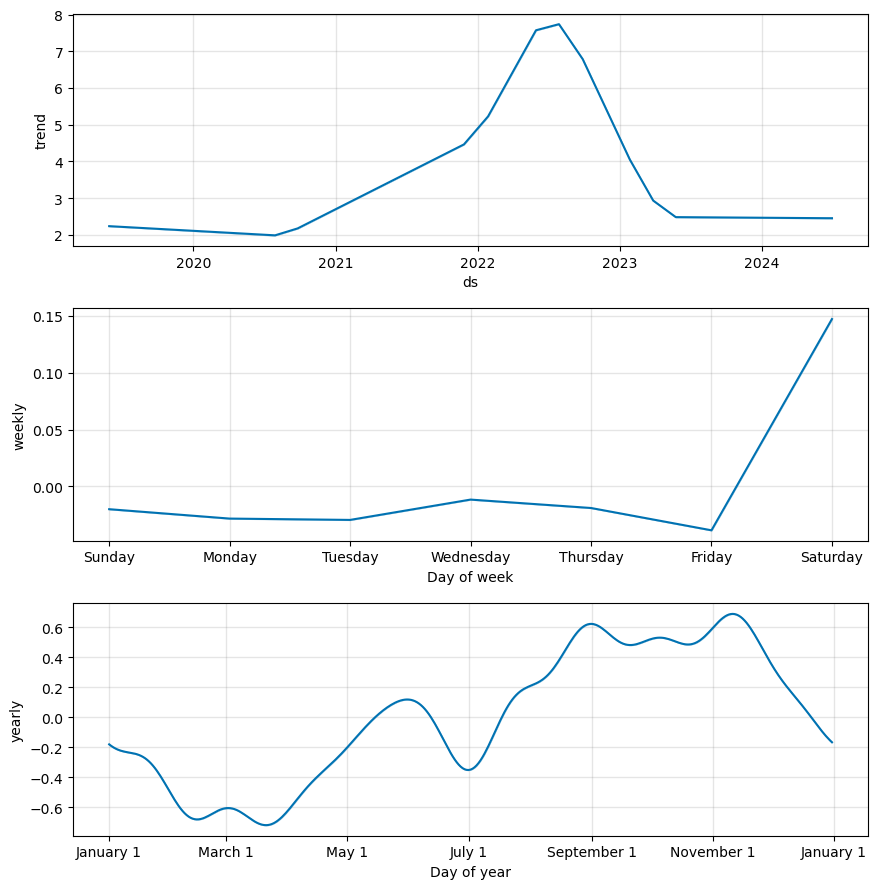

In [35]:
fig2 = model.plot_components(forecast)